### #3

Kaggle competition: [\[link\]](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

Entry by Robin R.P.M. Kras

### ⭐ 1. Introduction & Overview


Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

### 🔹 2. Import Libraries & Set Up


In [65]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import xgboost as xg

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, roc_auc_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from imblearn.over_sampling import SMOTE

# Feature Importance & Explainability
import shap

# Settings
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

print("Libraries loaded. Ready to go!")

Libraries loaded. Ready to go!


### 🔹 3. Load & Explore Data


In [66]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [67]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [68]:
train.shape

(1460, 81)

In [69]:
train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [70]:
# Quick summary of dataset
train.describe()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### 🔹 4. Data Visualization & EDA



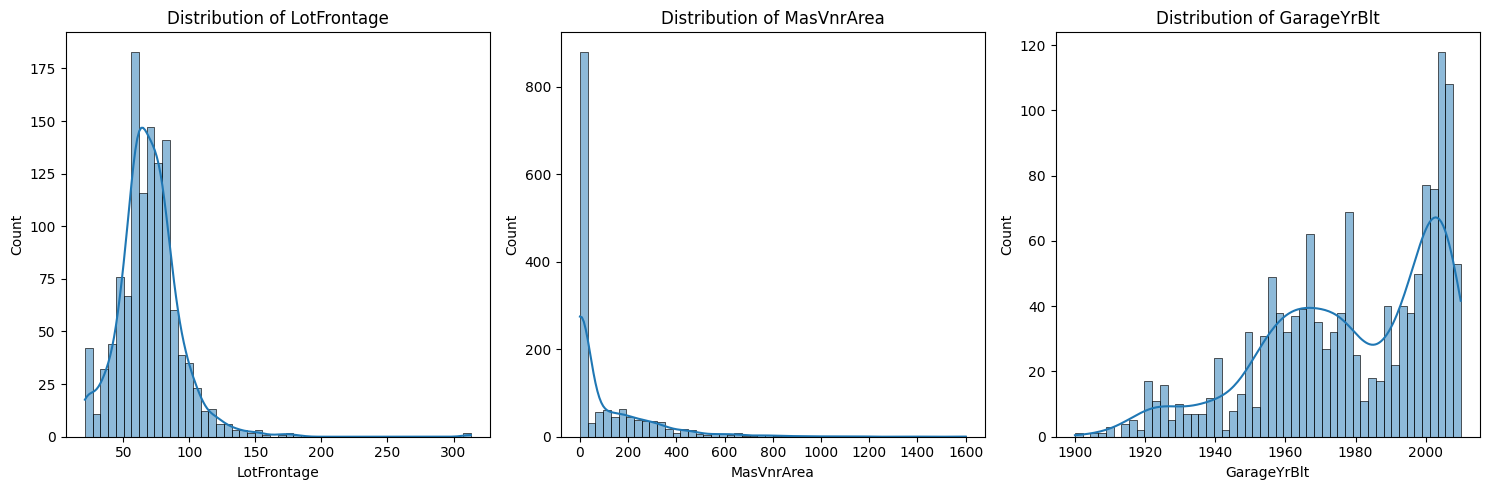

In [71]:
float_cols = [col for col in train.columns if train[col].dtype == "float64"]

cols_per_row = 3
num_plots = len(float_cols)
rows = (num_plots // cols_per_row) + (num_plots % cols_per_row > 0) 

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 5 * rows)) 
axes = axes.flatten()  

for idx, col in enumerate(float_cols):
    sns.histplot(train[col], bins=50, kde=True, ax=axes[idx])
    axes[idx].set_title(f"Distribution of {col}")

for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

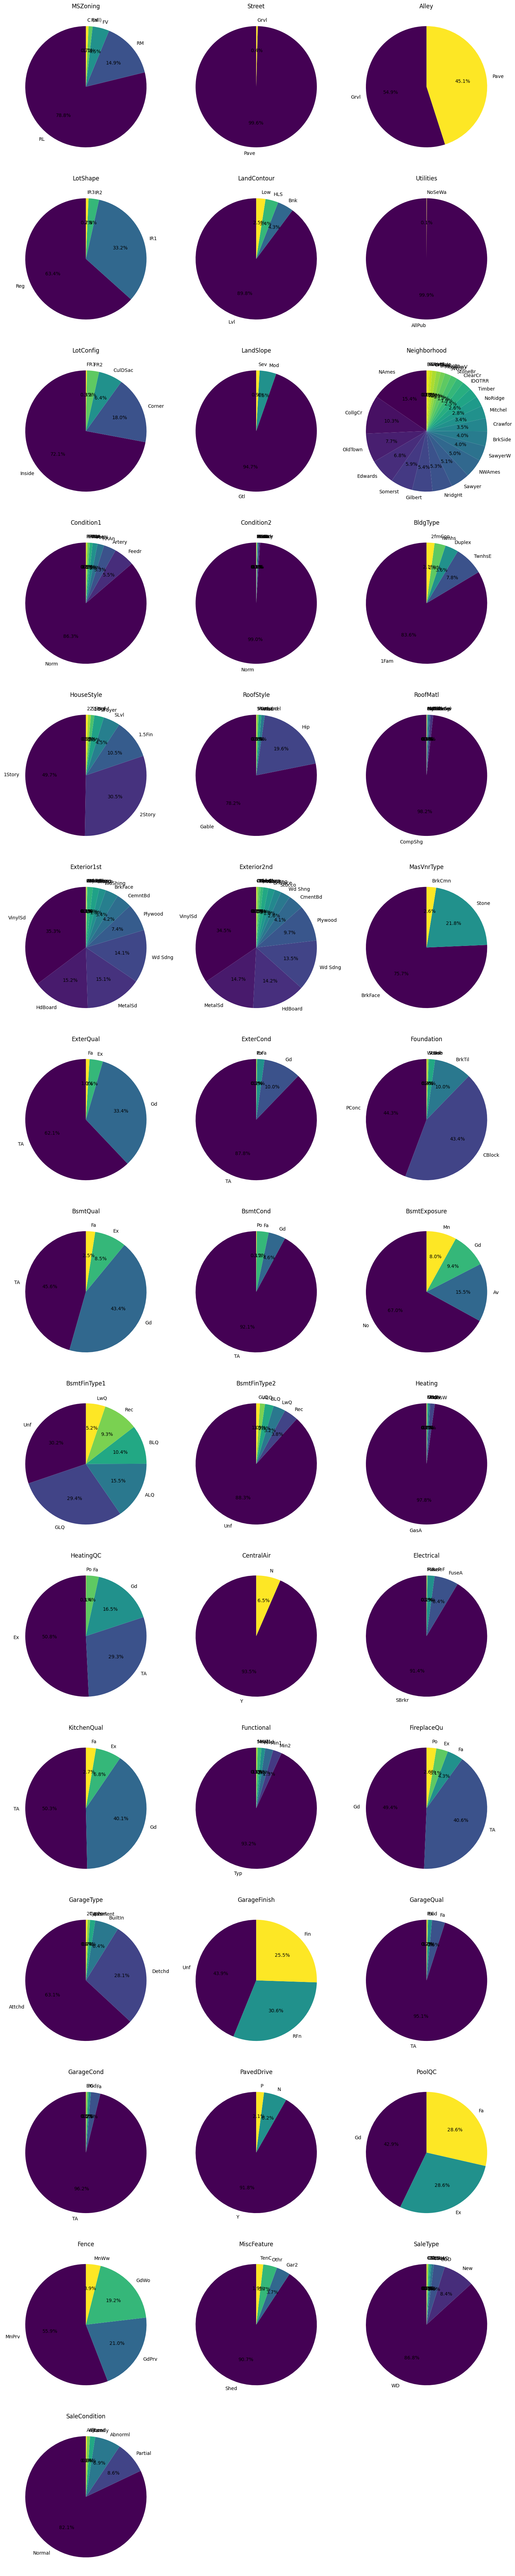

In [72]:
categorical_features = train.select_dtypes(include=['object']).columns

num_features = len(categorical_features)
cols = 3 
rows = (num_features // cols) + (num_features % cols > 0) 

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5)) 
axes = axes.flatten()  

for i, feature in enumerate(categorical_features):
    train[feature].value_counts().plot.pie(
        autopct='%1.1f%%', ax=axes[i], startangle=90, cmap="viridis"
    )
    axes[i].set_title(feature)
    axes[i].set_ylabel("") 

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


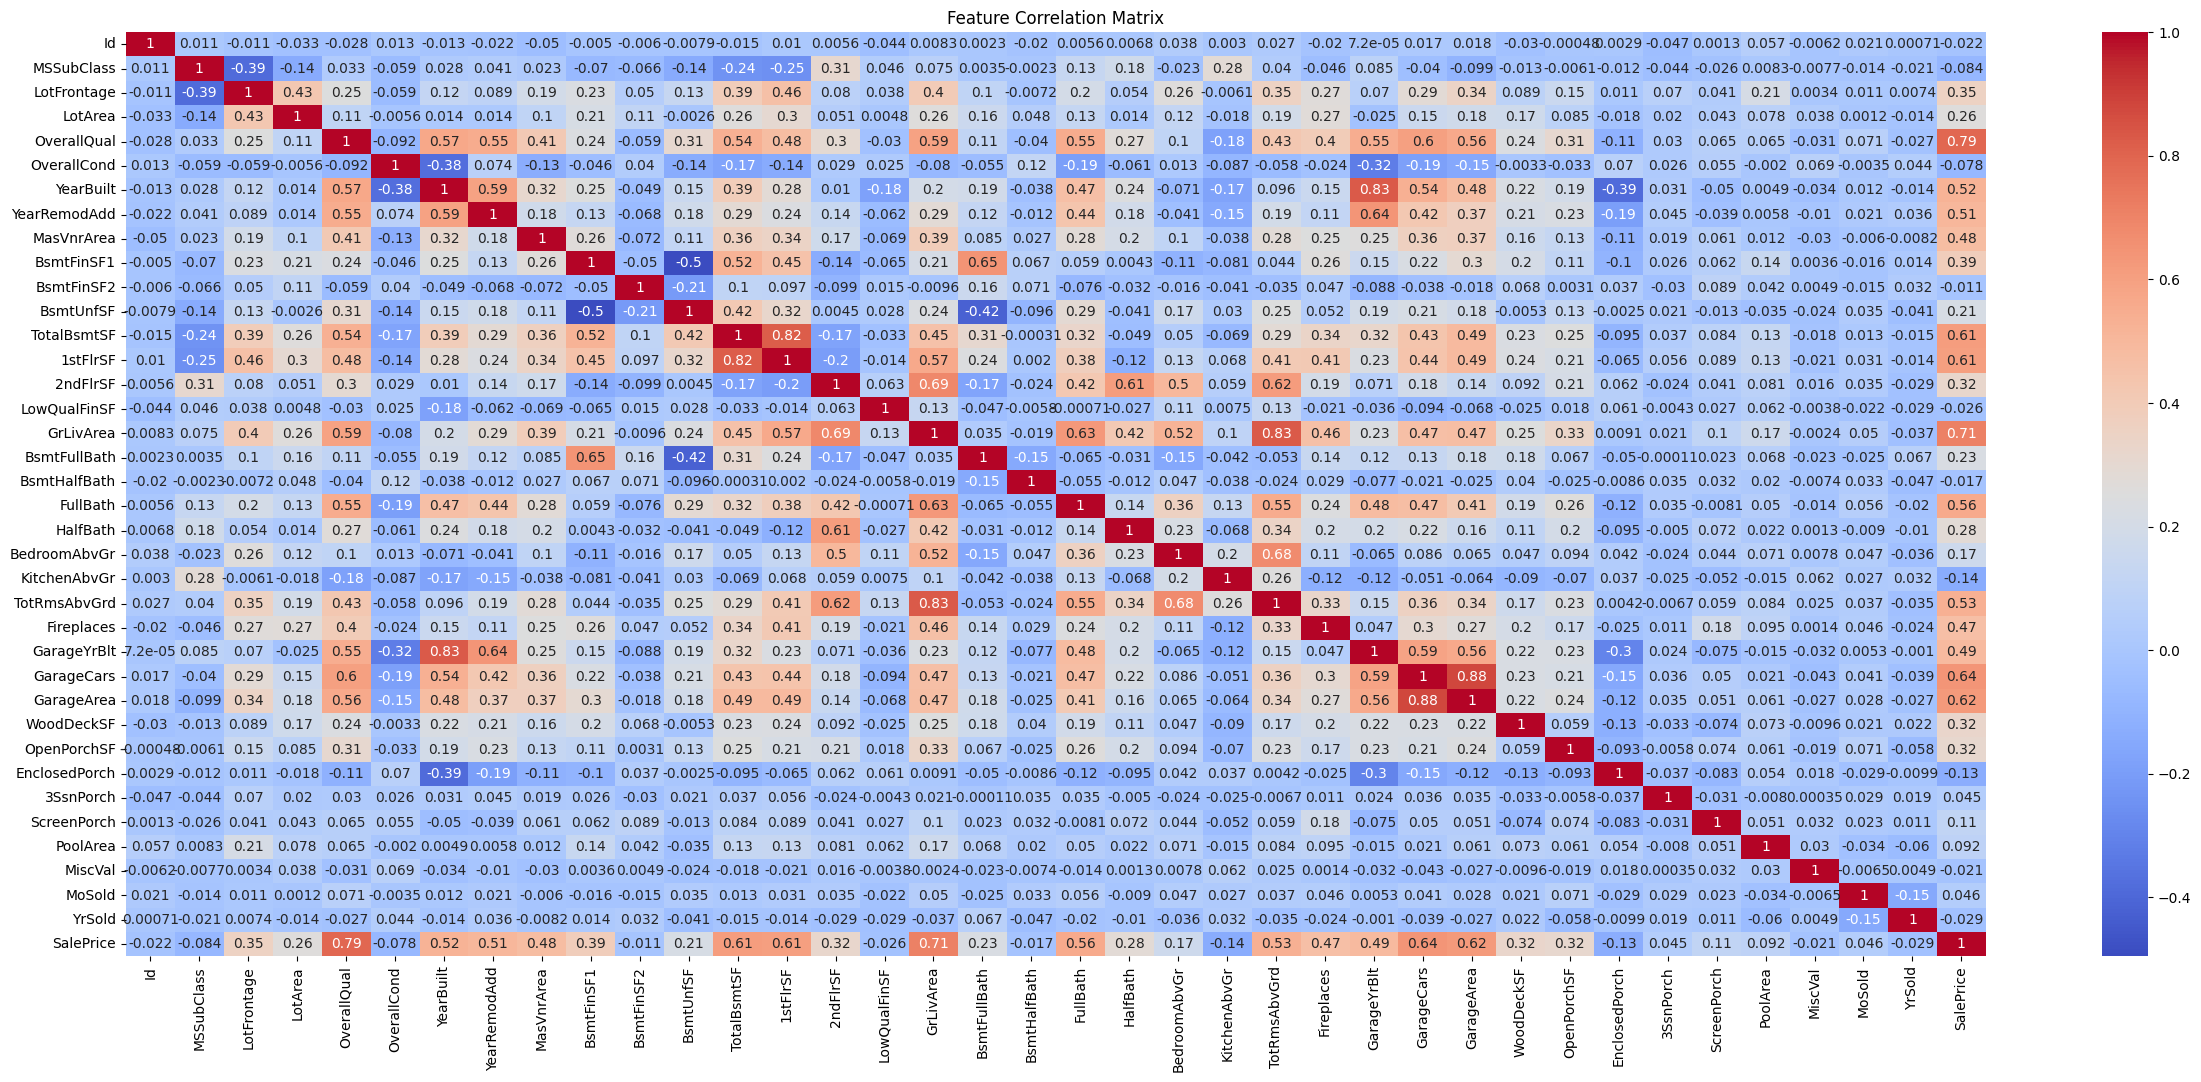

In [73]:
heatmap_train = pd.DataFrame()

for col in train.columns:
    if train[col].dtype == "float64" or train[col].dtype == "int64":
        heatmap_train[col] = train[col]

plt.figure(figsize=(30,12))
sns.heatmap(heatmap_train.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

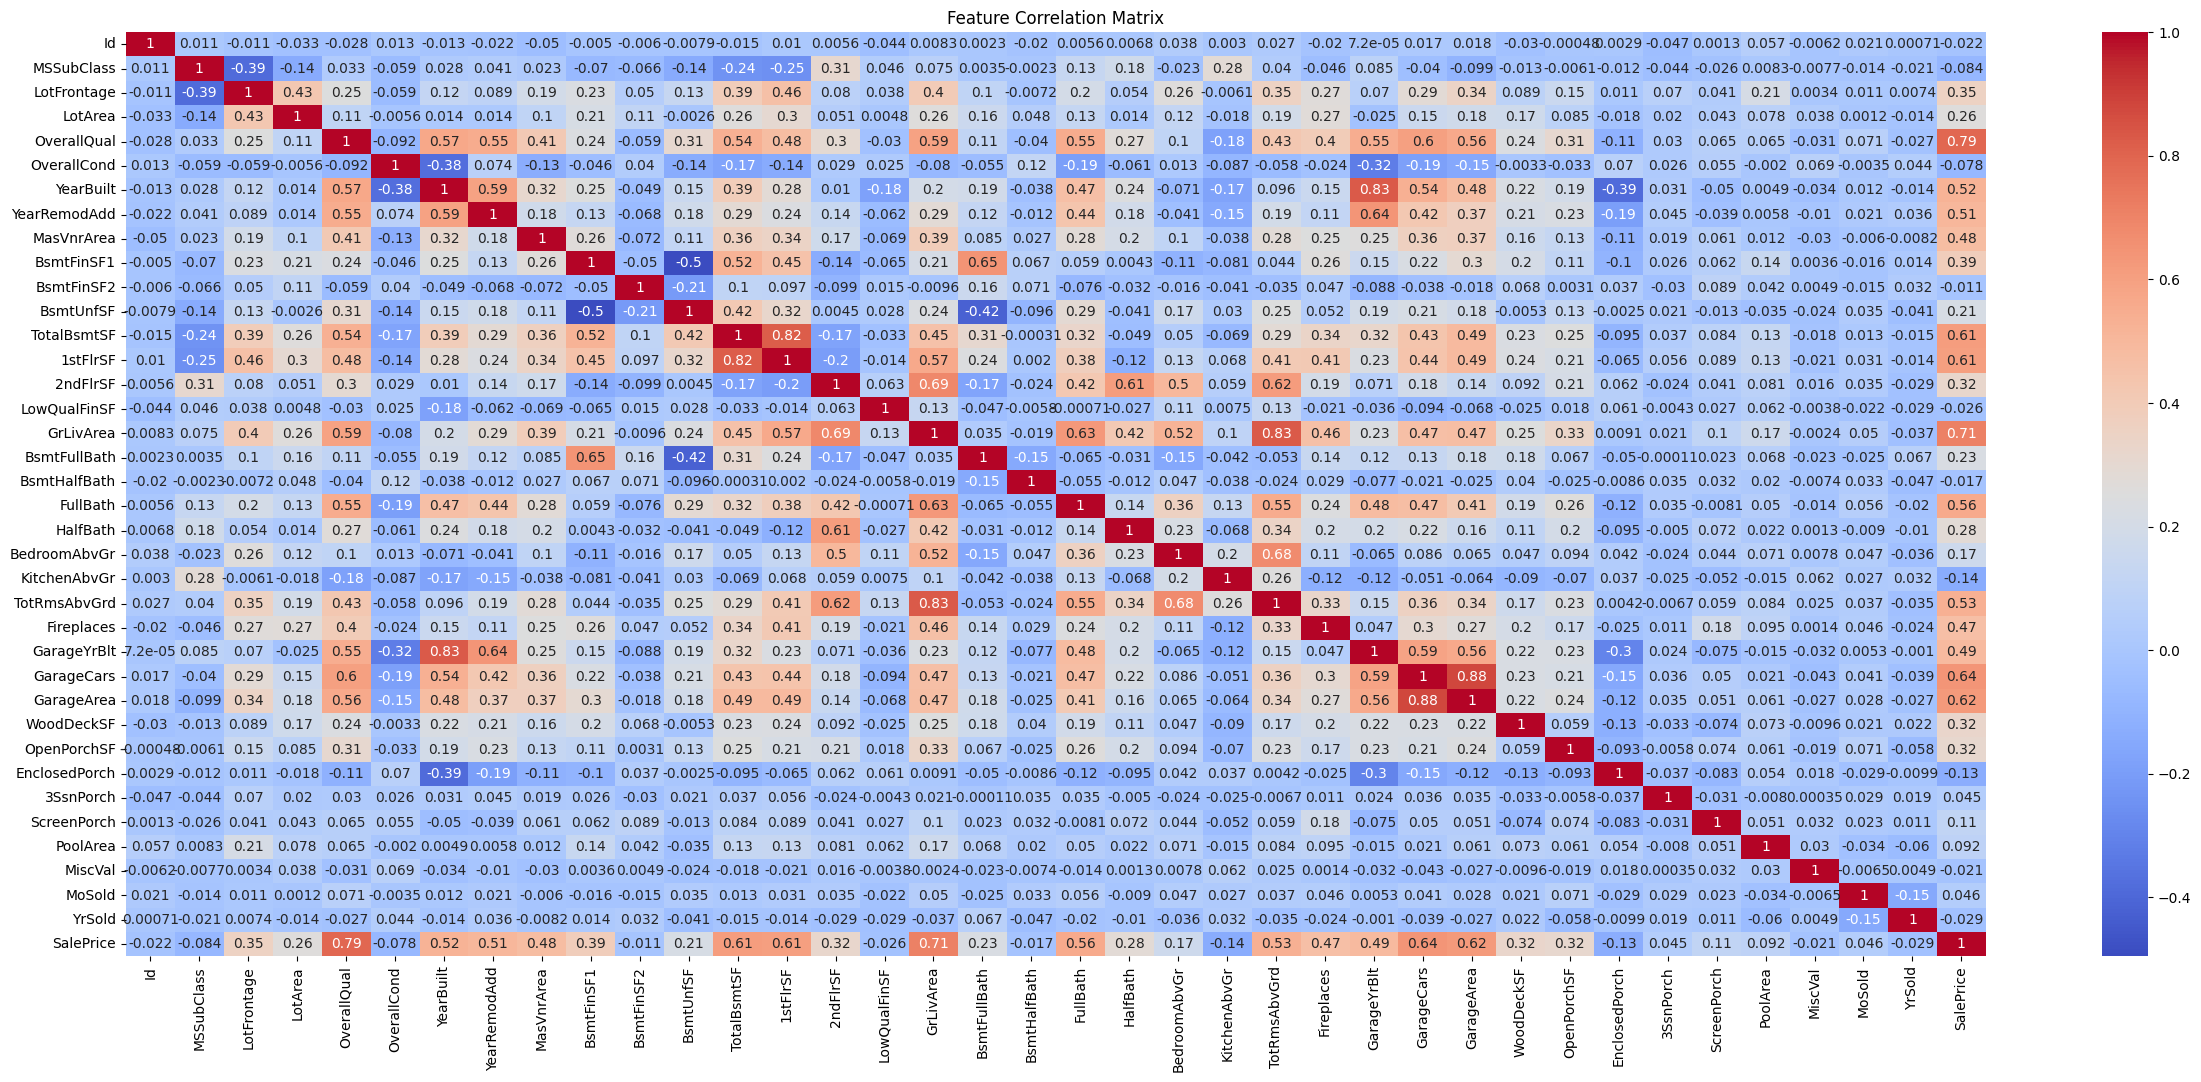

Highly correlated feature pairs (above threshold):
       Feature 1     Feature 2  Correlation
174  OverallQual     SalePrice     0.790982
225    YearBuilt   GarageYrBlt     0.825667
378  TotalBsmtSF      1stFlrSF     0.819530
478    GrLivArea  TotRmsAbvGrd     0.825489
637   GarageCars    GarageArea     0.882475


In [74]:
heatmap_train = train.select_dtypes(include=["float64", "int64"])

corr_matrix = heatmap_train.corr()

threshold = 0.75

high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) 
    .stack()  
    .reset_index()
)

high_corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]
high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"].abs() > threshold]  

plt.figure(figsize=(30, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

print("Highly correlated feature pairs (above threshold):")
print(high_corr_pairs)

In [75]:
l1 = high_corr_pairs['Feature 1'].tolist()
l2 = high_corr_pairs['Feature 2'].tolist()
interesting_features = list(set(l1+l2))

interesting_features.remove('SalePrice')

print(interesting_features)

['YearBuilt', 'GarageArea', 'TotRmsAbvGrd', 'GarageYrBlt', 'TotalBsmtSF', '1stFlrSF', 'GarageCars', 'OverallQual', 'GrLivArea']


### 🔹 5. Feature Engineering

In [76]:
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

In [77]:
print(f"Train set, null count: \n{train.isnull().sum()}")
print("\n")
print(f"Test set, null count: \n{test.isnull().sum()}")

Train set, null count: 
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


Test set, null count: 
Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64


In [78]:
outliers = pd.concat([
    train[(train['OverallQual'] == 4) & (train['SalePrice'] > 2e5)],
    train[(train['OverallQual'] == 8) & (train['SalePrice'] > 5e5)],
    train[(train['OverallQual'] == 10) & (train['SalePrice'] > 7e5)],
    train[(train['GrLivArea'] > 4000)],
    train[(train['OverallCond'] == 2) & (train['SalePrice'] > 3e5)],
    train[(train['OverallCond'] == 5) & (train['SalePrice'] > 7e5)],
    train[(train['OverallCond'] == 6) & (train['SalePrice'] > 7e5)]
]).sort_index().drop_duplicates()

In [79]:
train = train.drop(outliers.index)

In [80]:
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

In [81]:
for col in train.columns:
    if train[col].dtype == "object":
        train[col] = train[col].fillna("None")
    elif train[col].dtype in ["float64", "int64"]:
        train[col] = train[col].fillna(train[col].mean())

for col in test.columns:
    if test[col].dtype == "object":
        test[col] = test[col].fillna("None")
    elif test[col].dtype in ["float64", "int64"]:
        test[col] = test[col].fillna(test[col].mean())    

In [82]:
for col in train.columns:
    if train[col].isnull().sum() > 0:
        print(col)

for col in test.columns:
    if test[col].isnull().sum() > 0:
        print(col)

No more empty items left. Great!

In [83]:
import itertools

def create_combination_features(df, features):
    combinations = itertools.combinations(features, 2)

    for comb in combinations:
        feature_name = "_".join(comb)
        df[feature_name] = df[list(comb)].mean(axis=1)
    
    return df

train = create_combination_features(train, interesting_features)
test = create_combination_features(test, interesting_features)

In [84]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,TotalBsmtSF_1stFlrSF,TotalBsmtSF_GarageCars,TotalBsmtSF_OverallQual,TotalBsmtSF_GrLivArea,1stFlrSF_GarageCars,1stFlrSF_OverallQual,1stFlrSF_GrLivArea,GarageCars_OverallQual,GarageCars_GrLivArea,OverallQual_GrLivArea
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,856.0,429.0,431.5,1283.0,429.0,431.5,1283.0,4.5,856.0,858.5
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,1262.0,632.0,634.0,1262.0,632.0,634.0,1262.0,4.0,632.0,634.0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,920.0,461.0,463.5,1353.0,461.0,463.5,1353.0,4.5,894.0,896.5
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,858.5,379.5,381.5,1236.5,482.0,484.0,1339.0,5.0,860.0,862.0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,1145.0,574.0,576.5,1671.5,574.0,576.5,1671.5,5.5,1100.5,1103.0


In [85]:
le = LabelEncoder()

for col in train.columns:
    if train[col].dtype == "object":
        train[col] = le.fit_transform(train[col])

for col in test.columns:
    if test[col].dtype == "object":
        test[col] = le.fit_transform(test[col])

### 🔹 6. Model Selection

In [89]:
X = train.drop(columns=["Id", "SalePrice"])
X_test = test.drop(columns=['Id'])  

y = train['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [3, 5, 7, 9],  
    'subsample': [0.8, 0.9, 1.0], 
    'colsample_bytree': [0.8, 0.9, 1.0],
    'alpha': [0, 0.01, 0.1, 1],
    'lambda': [0, 0.1, 0.5, 1],
    'gamma': [0, 0.1, 0.2, 1],
    'early_stopping_rounds': [5, 10, 20, 30]
}

grid_search = GridSearchCV(xg.XGBRegressor(tree_method="gpu_hist", random_state=SEED), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)])

print("Best Parameters:", grid_search.best_params_)

best_params = grid_search.best_params_

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_predictions = np.zeros(len(train))

for train_idx, val_idx in kf.split(train):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = xg.XGBRegressor(**best_params)

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    oof_predictions[val_idx] = y_pred  # Store out-of-fold predictions
    
    print(f"Fold RMSE: {root_mean_squared_error(y_val, y_pred)}") # Change RMSE by accuracy/recall/f1-score for classification

final_rmse = root_mean_squared_error(y, oof_predictions)
print(f"Final Cross-Validation RMSE: {final_rmse}")


Fold RMSE: 23510.853515625
Fold RMSE: 24593.13671875
Fold RMSE: 27025.958984375
Fold RMSE: 24410.958984375
Fold RMSE: 21487.322265625
Final Cross-Validation RMSE: 24273.442706870697


In [91]:
predictions = model.predict(X_test)  

output = pd.DataFrame({'Id': test['Id'], 'SalePrice': predictions})
output.to_csv('submission_xgb.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


### 🔹 Experiment

[0]	validation_0-rmse:68626.07721	validation_1-rmse:72258.08294
[1]	validation_0-rmse:62854.93875	validation_1-rmse:66772.04603
[2]	validation_0-rmse:57619.17683	validation_1-rmse:61349.71447
[3]	validation_0-rmse:52937.04308	validation_1-rmse:56694.73902
[4]	validation_0-rmse:48650.87250	validation_1-rmse:52216.31762
[5]	validation_0-rmse:44804.70744	validation_1-rmse:48836.47042
[6]	validation_0-rmse:41266.45199	validation_1-rmse:45331.83450
[7]	validation_0-rmse:38081.24497	validation_1-rmse:42577.41073
[8]	validation_0-rmse:35209.05072	validation_1-rmse:40127.35297
[9]	validation_0-rmse:32570.91283	validation_1-rmse:37972.22511
[10]	validation_0-rmse:30196.15381	validation_1-rmse:35841.68373
[11]	validation_0-rmse:28076.53755	validation_1-rmse:34175.90371
[12]	validation_0-rmse:26120.43178	validation_1-rmse:32806.23747
[13]	validation_0-rmse:24345.91098	validation_1-rmse:31408.97480
[14]	validation_0-rmse:22774.49313	validation_1-rmse:30091.86559
[15]	validation_0-rmse:21319.17285	

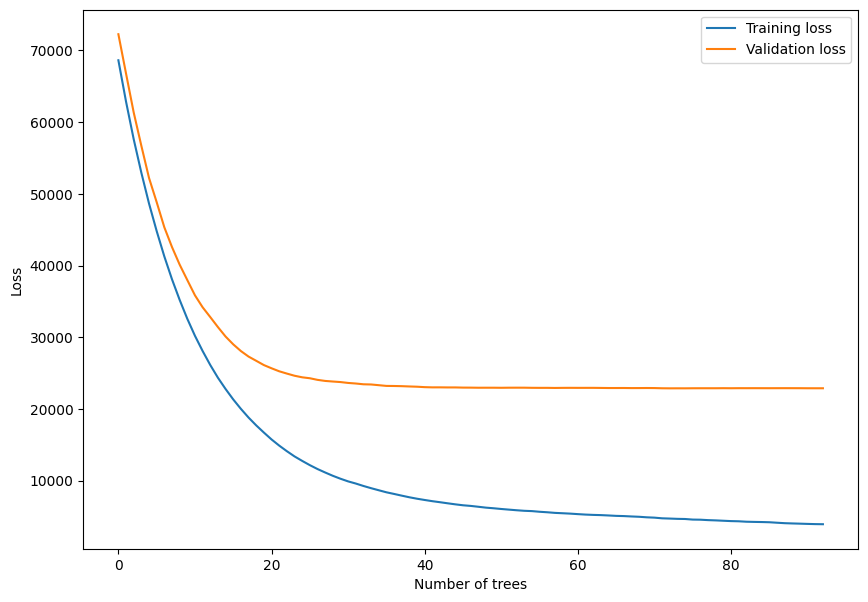

In [ ]:
y = train["SalePrice"]

X = pd.get_dummies(train.drop(columns=["SalePrice"]))
X_test = pd.get_dummies(test)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=SEED)

model = xg.XGBRegressor(
    **best_params,
    random_state=SEED)
    
model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)])

results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

rms = min(results["validation_1"].values(), key=min)
rms = min(rms)

predictions = model.predict(X_test)
predictions_val = model.predict(X_val)

print(f"RMSE Score: {rms}")

output = pd.DataFrame({'Id': test['Id'], 'SalePrice': predictions})
output.to_csv('submission_experiment.csv', index=False)
print("Your submission was successfully saved!")

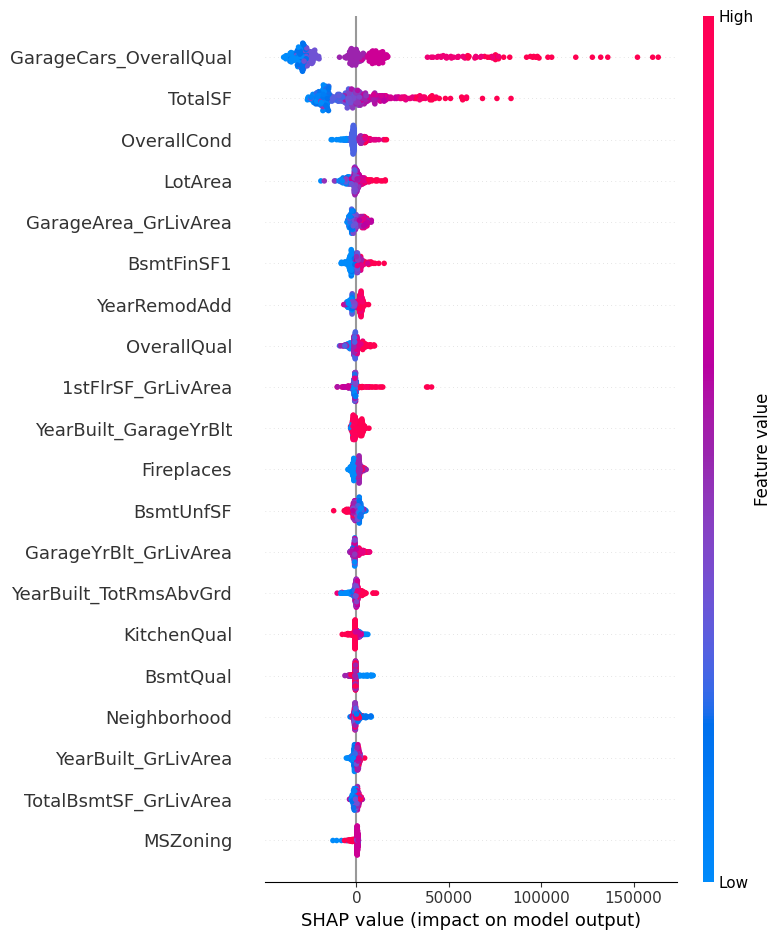

In [ ]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val)
shap.force_plot(explainer.expected_value, shap_values[0], X_val.iloc[0])